In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.path as mpath
from matplotlib import rc
import matplotlib.pyplot as plt
import netCDF4 as nc 
import pandas as pd 
import xarray as xr
import seaborn as sns
import scipy
import dask
import h5py
import matplotlib.animation as animation
from matplotlib.colors import TwoSlopeNorm
from IPython.display import HTML
from PIL import Image
from cycler import cycler
import cmocean

np.random.seed(4321)
plt.rcParams.update({'font.size': 12})
print('all done')
%matplotlib inline
nanmasked = plt.get_cmap('RdBu').copy()
nanmasked.set_bad('black')
nanmasked2 = mpl.colors.LinearSegmentedColormap.from_list("", ["white","red"])
nanmasked2.set_under('black')
nanmasked2.set_bad('black')

all done


In [4]:
# data_path = '/scratch/gpfs/CDEUTSCH/wchu/corals/nwa12_po2_zl030.nc'
# data_path = '/scratch/gpfs/CDEUTSCH/wchu/corals/nwa12_monthly_o2.nc'
data_path = '/scratch/gpfs/CDEUTSCH/wchu/may_data/nwa12_o2b.nc'
ds = xr.open_dataset(data_path,chunks='auto')
data_path = '/scratch/gpfs/CDEUTSCH/wchu/corals/nwa12_ocean_static.nc'
ds = xr.merge([ds, xr.open_dataset(data_path)])
ds = ds.isel(xh=slice(0,600),yh=slice(0,350))

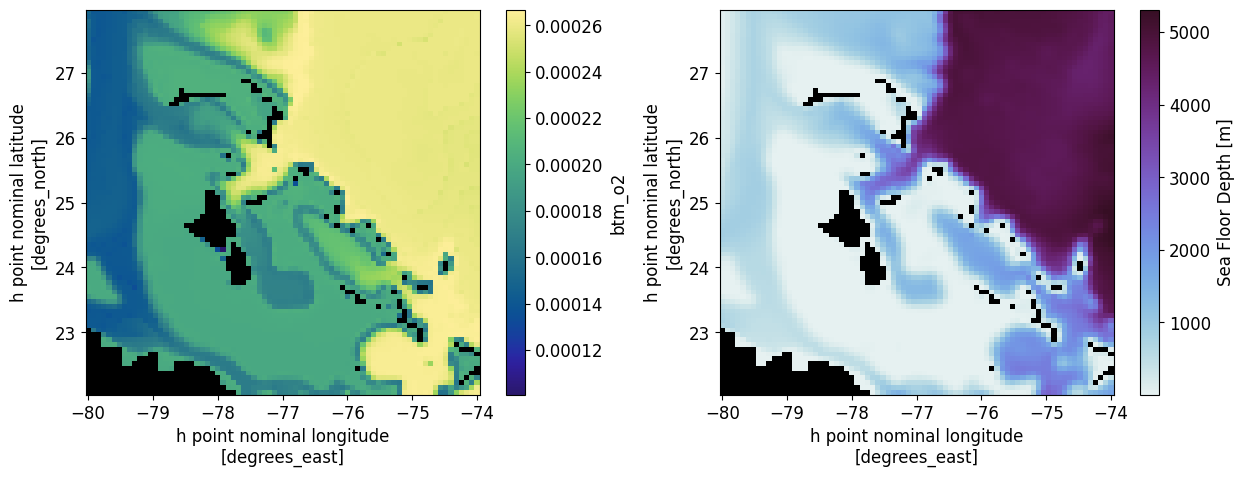

In [18]:
test = ds.btm_o2.sel(**{'xh': slice(-80, -74),'yh': slice(22, 28)})
# test = test - test.mean(['xh','yh'])
fig, ax = plt.subplots(1, 2, figsize = (15,5))
nanmasked = plt.get_cmap('cmo.haline').copy()
nanmasked.set_bad('black')
test.mean('time').plot(x='xh',y='yh',cmap=nanmasked,ax=ax[0])
ax[0].set_aspect('equal')
nanmasked = plt.get_cmap('cmo.dense').copy()
nanmasked.set_bad('black')
ds.deptho.sel(**{'xh': slice(-80, -74),'yh': slice(22, 28)}).plot(x='xh',y='yh',cmap=nanmasked, ax=ax[1])
ax[1].set_aspect('equal')

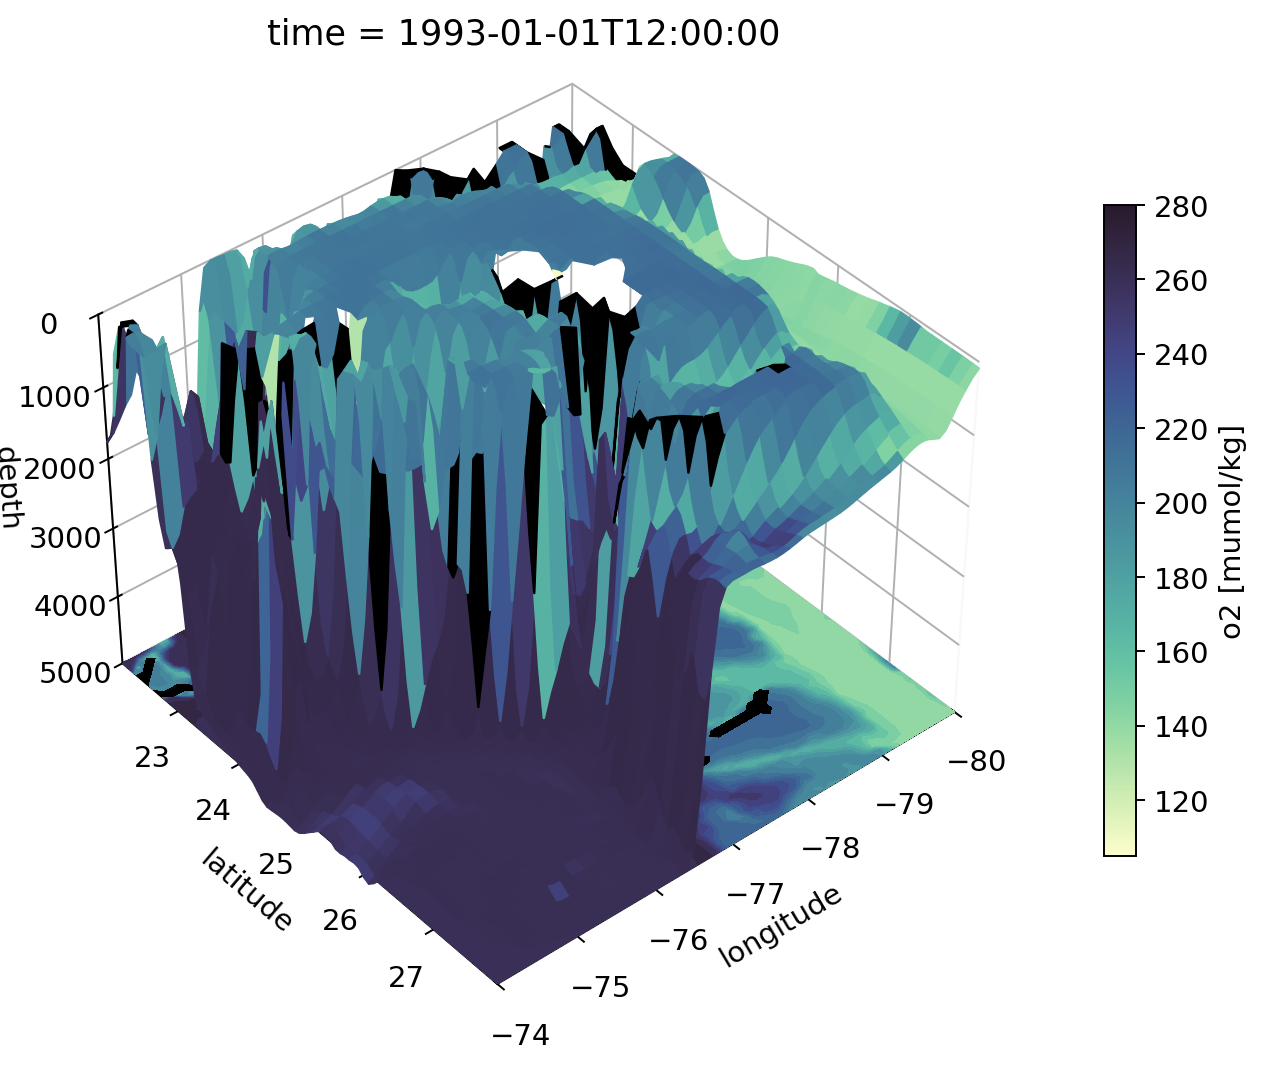

In [168]:
# norm = mpl.colors.Normalize(vmin=105, vmax=280) 
# cmap =cmocean.cm.deep
# sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)    
# sm.set_array([]) 

# bahamas = ds.isel(time=1).sel(**{'xh': slice(-80, -74),'yh': slice(22, 28)})

# colors = [(1,1,1,0) for c in np.linspace(0,1,2)]
# nanmasked2 = mpl.colors.LinearSegmentedColormap.from_list("", colors,N=1)
# nanmasked2.set_under('black')
fig, ax = plt.subplots(1, 1, figsize=(8,8), subplot_kw={'projection': '3d'}, dpi=175)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
bahamas.deptho.plot.surface(x='xh',y='yh',facecolors=cmap(norm(1e6*bahamas.btm_o2)),shade=False)#True,lightsource=mpl.colors.LightSource(180,0))
fig.colorbar(sm,ax=ax,fraction=0.03,pad=0.1,label='o2 [mumol/kg]')
C = ax.contourf(bahamas.xh.values, bahamas.yh.values, bahamas.btm_o2.where(np.isnan(bahamas.btm_o2)==0,-1).values, zdir='z', levels=40, offset=5000, vmin=0, vmax=5000,cmap=nanmasked2)#cmap=cmap.set_bad('black')) #, norm = mpl.colors.Normalize(vmin=-0.03, vmax=0.03))
ax.contourf(bahamas.xh.values, bahamas.yh.values, 1e6*bahamas.btm_o2.values, zdir='z', norm=norm,levels=20, offset=5000, cmap=cmap)#cmap=cmap.set_bad('black')) #, norm = mpl.colors.Normalize(vmin=-0.03, vmax=0.03))
ax.set(xlabel='longitude', ylabel='latitude', zlabel='depth')
xmin, xmax = bahamas.xh.min(), bahamas.xh.max()
ymin, ymax = bahamas.yh.min(), bahamas.yh.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[5000, 0])
# ax.set_box_aspect(((xmax-xmin)/(ymax-ymin), 1, 1))
# fig.tight_layout()
ax.view_init(40, 50)
plt.show()
# plt.imshow(cmap(norm(ds.btm_o2.isel(time=2))))

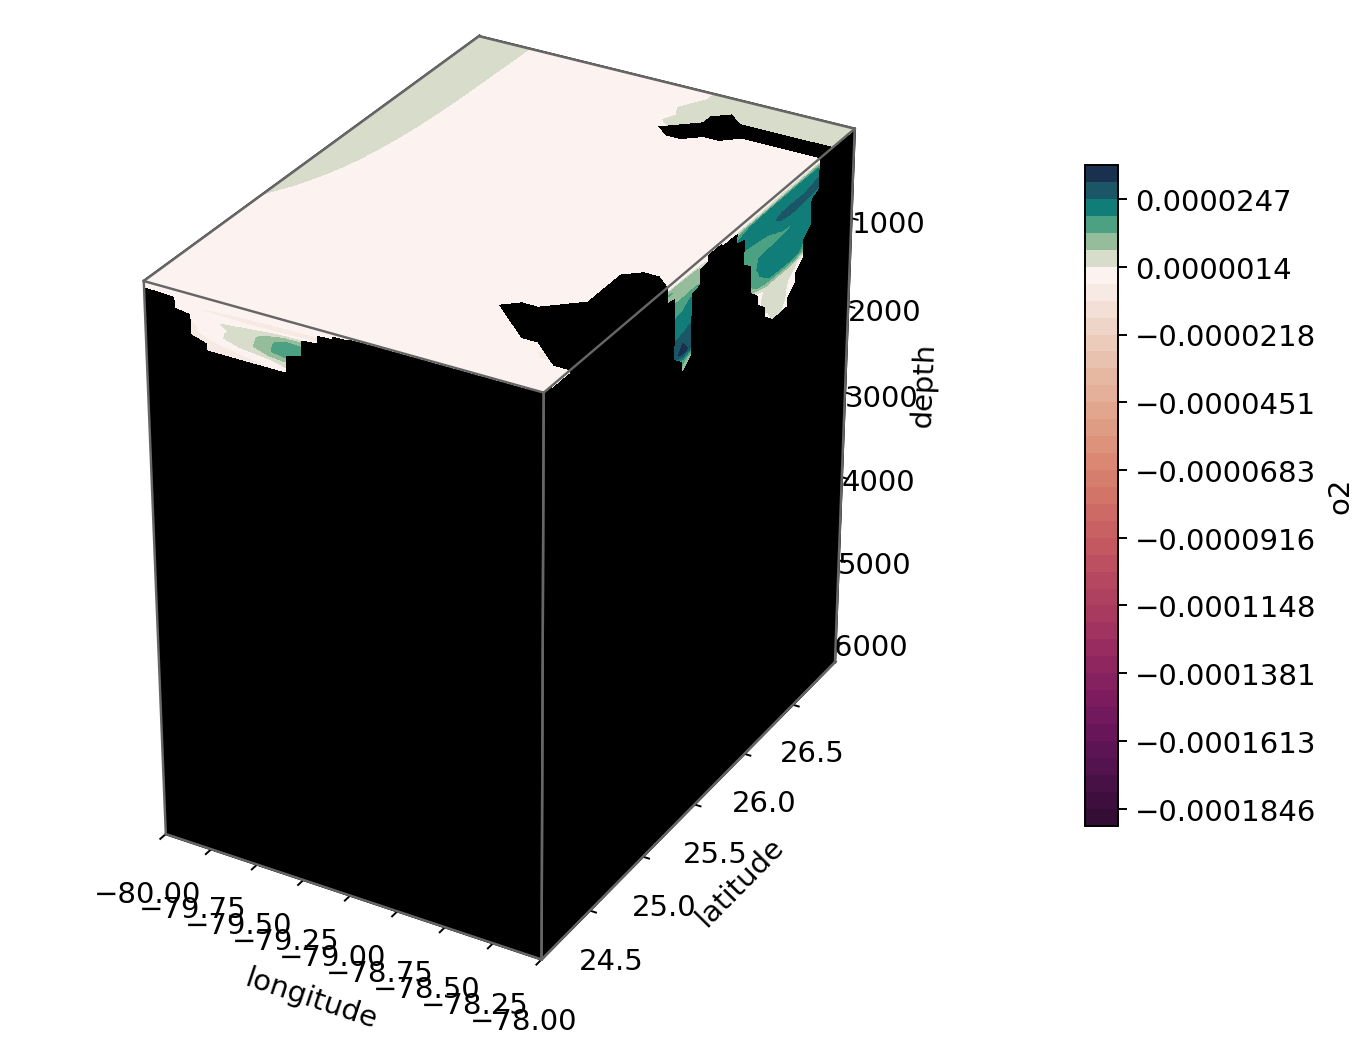

In [24]:
test = ds.sel(**{'xh': slice(-80, -78),'yh': slice(24, 27)}) #.isel(z_l=slice(0,10))
test = test - test.mean(['xh','yh'])
# test2 = test.groupby('time.month').mean('time')
make_a_cube(test,'o2',9,1)
# ds

In [19]:
def make_a_cube(ds_model, var, month, div):
    # plot a 3d cube plot of the prediction or training data
    # var is variable name as string, i.e., 'thetao' for temp
    # ex: make_a_cube(dspo2, 'thetao',2,1) where div=1 so we plot on a diverging colorbar, month=2 so feb of 1993
    # for a specified section with lat lon, use this dspo2.po2.sel(**{'xh': slice(-92, -90),'yh': slice(21, 23)}) to select by lat/lon

    # min_var = min(ds_model[var].isel(z_l=0,time=month).min().values, ds_model[var].isel(yh=0,time=month).min().values, ds_model[var].isel(xh=-1,time=month).min().values)
    # max_var = max(ds_model[var].isel(z_l=0,time=month).max().values, ds_model[var].isel(yh=0,time=month).max().values, ds_model[var].isel(xh=-1,time=month).max().values)
    min_var = min(ds_model[var].isel(z_l=0).min().values, ds_model[var].isel(yh=0).min().values, ds_model[var].isel(xh=-1).min().values)
    max_var = max(ds_model[var].isel(z_l=0).max().values, ds_model[var].isel(yh=0).max().values, ds_model[var].isel(xh=-1).max().values)
    # min_var=0.17
    levels = np.linspace(min_var, max_var, 40)
    
    # Create a figure with 3D ax
    fig, ax = plt.subplots(1, 1, figsize=(8,8), subplot_kw={'projection': '3d'}, dpi=175)
    # ax.set_pane_color('black') 
    # #Set limits of the plot from coord limits
    xmin, xmax = ds_model.xh.min(), ds_model.xh.max()
    ymin, ymax = ds_model.yh.min(), ds_model.yh.max()
    zmin, zmax = ds_model.z_l.max(), ds_model.z_l.min()
    ax.xaxis.pane.fill = True
    ax.yaxis.pane.fill = True
    ax.zaxis.pane.fill = True
    ax.xaxis.set_pane_color('black') # make background of panes black so that land does not show
    ax.yaxis.set_pane_color('black')
    ax.zaxis.set_pane_color('black')
    
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    
    ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])
    ax.set_box_aspect(((xmax-xmin)/(ymax-ymin), 1, 1))
    # Plot edges
    edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
    ax.plot([xmax, xmax], [ymin, ymax], zmin, **edges_kw)
    ax.plot([xmax, xmax], [ymin, ymax], zmax, **edges_kw)
    ax.plot([xmin, xmax], [ymin, ymin], zmax, **edges_kw)
    ax.plot([xmin, xmin], [ymin, ymax], zmax, **edges_kw)
    ax.plot([xmin, xmax], [ymin, ymin], zmin, **edges_kw)
    ax.plot([xmin, xmax], [ymax, ymax], zmax, **edges_kw)
    ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
    ax.plot([xmax, xmax], [ymax, ymax], [zmin, zmax], **edges_kw)
    ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
    ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
    # Set labels and zticks
    ax.set(xlabel='longitude', ylabel='latitude', zlabel='depth')

    if div==1:
        ## if we are plotting a diverging colormap
        cmap = cmocean.cm.curl_r
        cmap_list = [mpl.colors.to_rgba('black')] + [cmap(i) for i in range(cmap.N)]
        new_cmap = mpl.colors.ListedColormap(cmap_list)
        # XY plot ax.contourf(x,y,z)
        ax.contourf(ds_model.xh.values, ds_model.yh.values, ds_model[var].isel(z_l=0,time=month).values, zdir='z', levels=levels, offset=zmax, cmap=new_cmap, norm=TwoSlopeNorm(0)) #, norm = mpl.colors.Normalize(vmin=-0.03, vmax=0.03))
    
    #     ## XZ plot ax.contourf(x,z,y)
        ax.contourf(ds_model.xh.values, ds_model[var].isel(yh=0,time=month).T.values, ds_model.z_l.values, zdir='y', levels=levels, offset=ymin,cmap=new_cmap, norm=TwoSlopeNorm(0))#, norm = mpl.colors.Normalize(vmin=-0.03, vmax=0.03))
    
    #     ## YZ plot ax.contourf(z,x,y)
        C = ax.contourf(ds_model[var].isel(xh=-1,time=month).values, ds_model.yh.values, ds_model.z_l.values, zdir='x', levels=levels, offset=xmax,cmap=new_cmap, norm=TwoSlopeNorm(0))#, norm = mpl.colors.Normalize(vmin=-0.03, vmax=0.03))
    # #     # Colorbar
    elif div==0:
        ## if we are plotting a diverging colormap
        cmap = cmocean.cm.haline
        cmap_list = [mpl.colors.to_rgba('black')] + [cmap(i) for i in range(cmap.N)]
        new_cmap = mpl.colors.ListedColormap(cmap_list)
        # XY plot ax.contourf(x,y,z)
        ax.contourf(ds_model.xh.values, ds_model.yh.values, ds_model[var].isel(z_l=0,time=month).values, zdir='z', levels=levels, offset=zmax, cmap=new_cmap) #, norm = mpl.colors.Normalize(vmin=-0.03, vmax=0.03))
    
    #     ## XZ plot ax.contourf(x,z,y)
        ax.contourf(ds_model.xh.values, ds_model[var].isel(yh=0,time=month).T.values, ds_model.z_l.values, zdir='y', levels=levels, offset=ymin,cmap=new_cmap)#, norm = mpl.colors.Normalize(vmin=-0.03, vmax=0.03))
    
    #     ## YZ plot ax.contourf(z,x,y)
        C = ax.contourf(ds_model[var].isel(xh=-1,time=month).values, ds_model.yh.values, ds_model.z_l.values, zdir='x', levels=levels, offset=xmax,cmap=new_cmap)#, norm = mpl.colors.Normalize(vmin=-0.03, vmax=0.03))
    # #     # Colorbar
        
    cbar = fig.colorbar(C, ax=ax, pad=0.1, label=var, fraction=0.03)#, orientation='horizontal')

    # plt.suptitle('Date: ' + ds_model.time[month].dt.strftime('%Y-%m').values)
    # ax.text2D(0.05, 0.95, 'Date: ' + ds_model.time[month].dt.strftime('%Y-%m').values, transform=ax.transAxes)
    # Show Figure
    fig.tight_layout()
    plt.show()